In [1]:
from collections import Counter
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from typing import Dict, List, Tuple

### Helper Code

In [2]:
class State:
    def __init__(self, color: str) -> None:
        self.color = color

    def transition(self):
        pass


class Recovered(State):
    def __init__(self, color: str = 'green') -> None:
        super().__init__(color)

    def transition(self) -> State:
        return self
    

class Infectious(State):
    def __init__(self, color: str = 'red', masks: bool = False) -> None:
        super().__init__(color)
        self.n_days_to_recovered = int(np.ceil(np.random.lognormal(2.25, 0.105, 1)[0]))
        self.n_days_infectious = 0
        self.masks = masks

    def prob_infection(self) -> float:
        p_1c = 0.12 * 0.35 if self.masks else 0.12
        beta = -0.00504

        numerator = (p_1c / (1 - p_1c)) * np.exp(beta * (self.n_days_infectious ** 3 - 1))
        denominator = 1 + numerator
        prob_infection = numerator / denominator

        return prob_infection

    def transition(self) -> State:
        if self.n_days_infectious >= self.n_days_to_recovered:
            return Recovered()
        
        self.n_days_infectious += 1

        return self
    

class Exposed(State):
    def __init__(self, color: str = 'yellow', masks: bool = False) -> None:
        super().__init__(color)
        self.n_days_to_infectious = int(np.ceil(np.random.lognormal(1.0, 1.0, 1)[0]))
        self.n_days_exposed = 0
        self.masks = masks

    def transition(self) -> State:
        if self.n_days_exposed >= self.n_days_to_infectious:
            return Infectious(self.masks)

        self.n_days_exposed += 1
        
        return self


class Susceptible(State):
    def __init__(self, neighbors: List, color: str = 'blue', masks: bool = False) -> None:
        super().__init__(color)
        self.neighbors = neighbors
        self.masks = masks

    def transition(self) -> State:
        for neighbor in self.neighbors:
            if isinstance(neighbor.curr_state, Infectious):
                prob_infected = neighbor.curr_state.prob_infection()
                random_sample = np.random.uniform()
                
                if random_sample < prob_infected:
                    return Exposed(self.masks)
                
        return self

In [3]:
class Agent:
    def __init__(self, initial_state_type: type, masks: bool = False) -> None:
        assert issubclass(initial_state_type, State)
        self.initial_state_type = initial_state_type
        self.masks = masks
        self.neighbors = []
        self.curr_state = None

    def transition(self) -> None:
        assert self.curr_state is not None
        self.curr_state = self.curr_state.transition()

    def add_neighbor(self, neighbor) -> None:
        self.neighbors.append(neighbor)

    def set_initial_state(self) -> None:
        self.curr_state = self._initialize_state()

    def _initialize_state(self) -> State:
        if self.initial_state_type == Susceptible:
            return Susceptible(self.neighbors, self.masks)
        
        elif self.initial_state_type == Exposed:
            return Exposed(self.masks)
        
        elif self.initial_state_type == Infectious:
            return Infectious(self.masks)
        
        else:
            return Recovered()

In [4]:
class Population:
    def __init__(self, graph: nx.Graph, percent_susceptible: float = 0.9, percent_exposed: float = 0.05, 
                 percent_infectious: float = 0.05, masks: bool = False) -> None:
        assert percent_susceptible + percent_exposed + percent_infectious == 1.0
        self.graph = graph
        self.percent_susceptible = percent_susceptible
        self.percent_exposed = percent_exposed
        self.percent_infectious = percent_infectious
        self.masks = masks
        self.agents = self._initialize_agents()

    def _initialize_agents(self) -> Dict:
        agents = {}
        n_nodes = self.graph.number_of_nodes()
        node_numbers = list(range(n_nodes))
        np.random.shuffle(node_numbers)
        n_susceptible = int(n_nodes * self.percent_susceptible)
        n_exposed = int(n_nodes * self.percent_exposed)
        susceptible_indices = set(node_numbers[:n_susceptible])
        exposed_indices = set(node_numbers[n_susceptible:n_susceptible + n_exposed])
        infectious_indices = set(node_numbers[n_susceptible + n_exposed:])
        curr_index = 0

        assert len(susceptible_indices) == n_susceptible
        assert len(exposed_indices) == n_exposed
        assert len(infectious_indices) == n_nodes - (n_susceptible + n_exposed)

        for node in self.graph.nodes:
            if curr_index in susceptible_indices:
                initial_state_type = Susceptible

            elif curr_index in exposed_indices:
                initial_state_type = Exposed

            else:
                initial_state_type = Infectious

            agents[node] = Agent(initial_state_type, self.masks)
            curr_index += 1

        for node in self.graph.nodes:
            neighbors = self.graph.neighbors(node)

            for neighbor in neighbors:
                neighbor_agent = agents[neighbor]
                agents[node].add_neighbor(neighbor_agent)

            agents[node].set_initial_state()

        return agents
    
    def transition(self) -> None:
        for agent in self.agents.values():
            agent.transition()
    
    def n_agents_with_type(self, state_type: type) -> int:
        assert issubclass(state_type, State)

        n_with_type = 0

        for agent in self.agents.values():
            n_with_type += 1 if isinstance(agent.curr_state, state_type) else 0

        return n_with_type
    
    def nodes_with_type(self, state_type: type) -> List[Tuple[object, str]]:
        nodes_with_type = [(node_label, agent.curr_state.color) for node_label, agent 
                           in self.agents.items() if isinstance(agent.curr_state, state_type)]
        
        return nodes_with_type
    
    def reset(self) -> None:
        self.agents = self._initialize_agents()

In [5]:
class Simulation:
    def __init__(self, name: str, population: Population, n_iterations: int = 200, n_trials: int = 100) -> None:
        self.name = name
        self.population = population
        self.n_iterations = n_iterations
        self.n_trials = n_trials
        self.susceptible_counts, self.exposed_counts, self.infectious_counts, self.recovered_counts = [], [], [], []

    def run(self, animate: bool = False) -> None:
        node_colors = []

        for _ in range(self.n_trials):
            s_counts, e_counts, i_counts, r_counts = [], [], [], []

            for _ in range(self.n_iterations):
                for state_type, count_array in [(Susceptible, s_counts), 
                                                (Exposed, e_counts), 
                                                (Infectious, i_counts), 
                                                (Recovered, r_counts)]:
                    n_agents_with_type = self.population.n_agents_with_type(state_type)
                    count_array.append(n_agents_with_type)

                if animate and len(node_colors) < self.n_iterations:
                    for state_type in [Susceptible, Exposed, Infectious, Recovered]:
                        nodes_with_type = self.population.nodes_with_type(state_type)
                        node_colors.append(nodes_with_type)

                self.population.transition()

            self.susceptible_counts.append(s_counts)
            self.exposed_counts.append(e_counts)
            self.infectious_counts.append(i_counts)
            self.recovered_counts.append(r_counts)

            self.population.reset()

        if animate:
            graph = self.population.graph
            fig = plt.figure()
            first_frame, node_positions = True, {}

            for node in graph.nodes:
                node_positions[node] = (np.random.uniform(0, 1), np.random.uniform(0, 1))

            def update(frame: int) -> None:
                # global first_frame

                # if frame == 0 and first_frame:
                #     first_frame = False
                #     nx.draw(graph, node_positions, with_labels=True)
                #     return
                
                color_mapping = {}
                colors = node_colors[frame]

                for node, color in colors:
                    color_mapping[node] = color

                print(color_mapping)
                print([node_colors[node] for node in graph.nodes])

                nx.draw(graph, node_positions, with_labels=True, node_color=[node_colors[node] for node in graph.nodes])

            ani = FuncAnimation(fig, update, frames=self.n_iterations, repeat=False)
            ani.save(f'./project_1_animations/animation_{self.name}.gif', writer='imagemagick', fps=0.5)

    def plot(self) -> None:
        assert len(self.susceptible_counts) == len(self.exposed_counts) == len(self.infectious_counts) == len(self.recovered_counts) == self.n_trials
        assert len(self.susceptible_counts[0]) == len(self.exposed_counts[0]) == len(self.infectious_counts[0]) == len(self.recovered_counts[0]) == self.n_iterations

        x_vals = range(self.n_iterations)

        s_mean = np.mean(self.susceptible_counts, axis=0)
        s_25 = np.percentile(self.susceptible_counts, 25, axis=0)
        s_75 = np.percentile(self.susceptible_counts, 75, axis=0)
        plt.plot(x_vals, s_mean, label='S', color='blue')
        plt.fill_between(x_vals, s_25, s_75, color='blue', alpha=0.5)

        e_mean = np.mean(self.exposed_counts, axis=0)
        e_25 = np.percentile(self.exposed_counts, 25, axis=0)
        e_75 = np.percentile(self.exposed_counts, 75, axis=0)
        plt.plot(x_vals, e_mean, label='E', color='yellow')
        plt.fill_between(x_vals, e_25, e_75, color='yellow', alpha=0.5)

        i_mean = np.mean(self.infectious_counts, axis=0)
        i_25 = np.percentile(self.infectious_counts, 25, axis=0)
        i_75 = np.percentile(self.infectious_counts, 75, axis=0)
        plt.plot(x_vals, i_mean, label='I', color='red')
        plt.fill_between(x_vals, i_25, i_75, color='red', alpha=0.5)

        r_mean = np.mean(self.recovered_counts, axis=0)
        r_25 = np.percentile(self.recovered_counts, 25, axis=0)
        r_75 = np.percentile(self.recovered_counts, 75, axis=0)
        plt.plot(x_vals, r_mean, label='I', color='green')
        plt.fill_between(x_vals, r_25, r_75, color='green', alpha=0.5)

        plt.legend(loc='best')
        plt.xlabel('Number of Days')
        plt.ylabel('Number of People')
        plt.title('Number of People in the S, E, I, or R States, Over Time')
        plt.show()

    def summary_statistics(self) -> None:
        i_mean = np.mean(self.infectious_counts, axis=0)
        e_mean = np.mean(self.exposed_counts, axis=0)
        s_mean = np.mean(self.susceptible_counts, axis=0)

        max_infections, time_to_max_infections = np.max(i_mean), np.argmax(i_mean)
        time_to_no_new_infections = np.where((i_mean == 0) & (e_mean == 0))[0][0]
        n_uninfected = s_mean[-1]

        print(f'Number of peak infections (on average): {max_infections}')
        print(f'Time to peak infection (on average): {time_to_max_infections}')
        print(f'Time until no new infections (on average): {time_to_no_new_infections}')
        print(f'Number of uninfected individuals at the end of the simulation (on average): {n_uninfected}')

    def graph_metrics(self) -> None:
        graph = self.population.graph

        degrees = dict(graph.degree()).values()
        degree_counts = Counter(degrees)

        plt.bar(degree_counts.keys(), degree_counts.values())
        plt.xlabel('Degree')
        plt.ylabel('Count')
        plt.title('Degree Distribution')
        plt.show()

        max_degree, avg_degree = max(degrees), sum(degrees) / len(degrees)
        diameter, radius, density = nx.diameter(graph), nx.radius(graph), nx.density(graph)

        print(f'Maximum degree: {max_degree}')
        print(f'Average degree: {avg_degree}')
        print(f'Diameter: {diameter}')
        print(f'Radius: {radius}')
        print(f'Density: {density}')

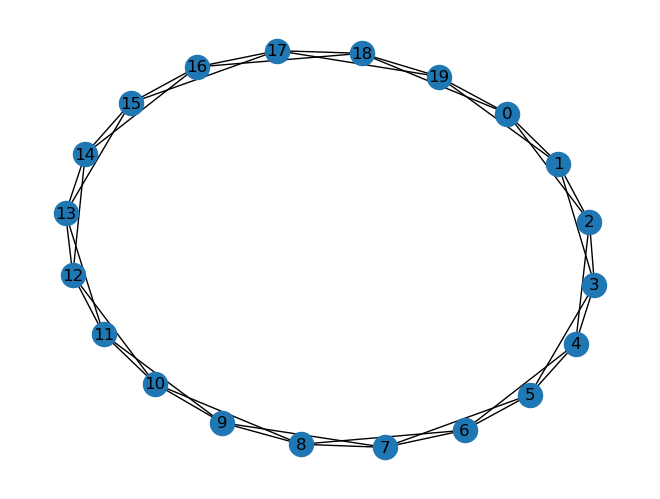

In [6]:
G = nx.circulant_graph(20, [1, 2])

nx.draw(G, with_labels=True)
plt.show()

In [7]:
population = Population(G)

In [8]:
circulant_2_sim = Simulation('circulant_2', population)

MovieWriter imagemagick unavailable; using Pillow instead.


{2: False, 3: False, 4: False, 5: False, 6: False, 7: False, 8: False, 9: False, 10: False, 11: False, 12: False, 13: False, 14: False, 15: False, 16: False, 17: False, 18: False, 19: False}
[[(2, False), (3, False), (4, False), (5, False), (6, False), (7, False), (8, False), (9, False), (10, False), (11, False), (12, False), (13, False), (14, False), (15, False), (16, False), (17, False), (18, False), (19, False)], [(1, False)], [(0, False)], [], [(3, False), (4, False), (5, False), (6, False), (7, False), (8, False), (9, False), (10, False), (11, False), (12, False), (13, False), (14, False), (15, False), (16, False), (17, False), (18, False), (19, False)], [(1, False), (2, False)], [(0, False)], [], [(3, False), (4, False), (5, False), (6, False), (7, False), (8, False), (9, False), (10, False), (11, False), (12, False), (13, False), (14, False), (15, False), (16, False), (17, False), (18, False), (19, False)], [(1, False), (2, False)], [(0, False)], [], [(3, False), (4, False), (5,

IndexError: list index out of range

{2: False, 3: False, 4: False, 5: False, 6: False, 7: False, 8: False, 9: False, 10: False, 11: False, 12: False, 13: False, 14: False, 15: False, 16: False, 17: False, 18: False, 19: False}
[[(2, False), (3, False), (4, False), (5, False), (6, False), (7, False), (8, False), (9, False), (10, False), (11, False), (12, False), (13, False), (14, False), (15, False), (16, False), (17, False), (18, False), (19, False)], [(1, False)], [(0, False)], [], [(3, False), (4, False), (5, False), (6, False), (7, False), (8, False), (9, False), (10, False), (11, False), (12, False), (13, False), (14, False), (15, False), (16, False), (17, False), (18, False), (19, False)], [(1, False), (2, False)], [(0, False)], [], [(3, False), (4, False), (5, False), (6, False), (7, False), (8, False), (9, False), (10, False), (11, False), (12, False), (13, False), (14, False), (15, False), (16, False), (17, False), (18, False), (19, False)], [(1, False), (2, False)], [(0, False)], [], [(3, False), (4, False), (5,

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [[(2, False), (3, False), (4, False), (5, False), (6, False), (7, False), (8, False), (9, False), (10, False), (11, False), (12, False), (13, False), (14, False), (15, False), (16, False), (17, False), (18, False), (19, False)], [(1, False)], [(0, False)], [], [(3, False), (4, False), (5, False), (6, False), (7, False), (8, False), (9, False), (10, False), (11, False), (12, False), (13, False), (14, False), (15, False), (16, False), (17, False), (18, False), (19, False)], [(1, False), (2, False)], [(0, False)], [], [(3, False), (4, False), (5, False), (6, False), (7, False), (8, False), (9, False), (10, False), (11, False), (12, False), (13, False), (14, False), (15, False), (16, False), (17, False), (18, False), (19, False)], [(1, False), (2, False)], [(0, False)], [], [(3, False), (4, False), (5, False), (6, False), (7, False), (8, False), (9, False), (10, False), (11, False), (12, False), (13, False), (14, False), (15, False), (16, False), (17, False), (19, False)], [(1, False), (2, False), (18, False)], [(0, False)], [], [(4, False), (5, False), (6, False), (7, False), (8, False), (9, False), (10, False), (11, False), (12, False), (13, False), (14, False), (15, False), (16, False), (17, False), (19, False)], [(1, False), (3, False), (18, False)], [(0, False), (2, False)], []]

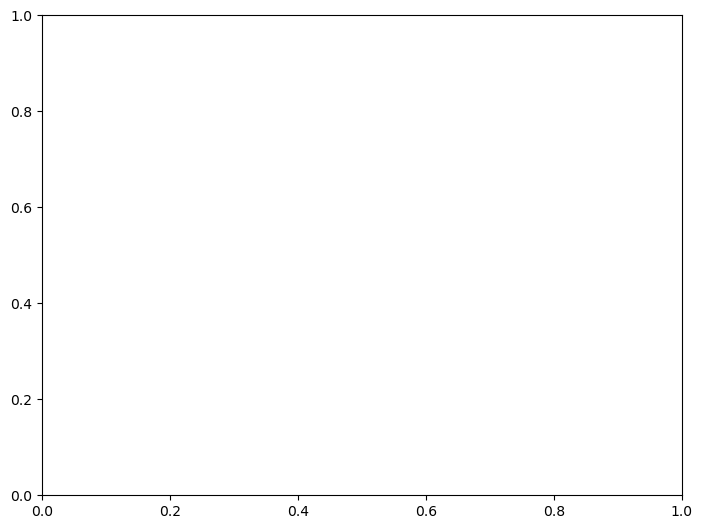

In [9]:
circulant_2_sim.run(animate=True)

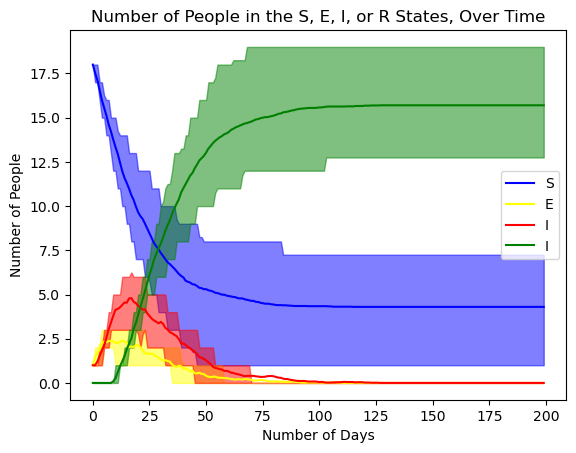

In [ ]:
circulant_2_sim.plot()

In [ ]:
circulant_2_sim.summary_statistics()

Number of peak infections (on average): 4.8
Time to peak infection (on average): 17
Time until no new infections (on average): 127
Number of uninfected individuals at the end of the simulation (on average): 4.3


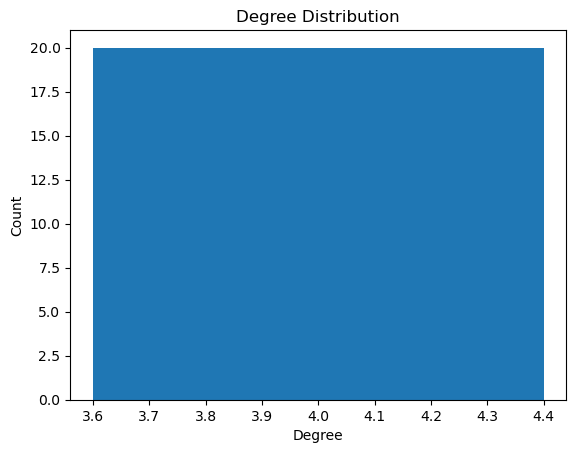

Maximum degree: 4
Average degree: 4.0
Diameter: 5
Radius: 5
Density: 0.21052631578947367


In [ ]:
circulant_2_sim.graph_metrics()